In [1]:
import json
import os

# Define Kaggle credentials
kaggle_creds = {
    "username": "hurryingauto3",
    "key": "17e33c07cfd0993aecbc770b33c7054e"
}

# Ensure the Kaggle config directory exists
os.makedirs(os.path.expanduser("~/.config/kaggle/"), exist_ok=True)

# Write credentials to kaggle.json
with open(os.path.expanduser("~/.config/kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_creds, f)

# Set correct permissions
os.chmod(os.path.expanduser("~/.config/kaggle/kaggle.json"), 0o600)

# Remove the "data/" directory if it exists
os.system("rm -rf data/")

0

In [2]:
import os
import zipfile
import pickle
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import torch.optim.swa_utils as swa_utils
import datetime

In [3]:
class CIFARTestDataset(Dataset):
    """
    Custom dataset for CIFAR-10 test images.

    Args:
        pkl_file (str): Path to the pickle file containing the test data.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, pkl_file, transform=None):
        with open(pkl_file, 'rb') as f:
            data_dict = pickle.load(f, encoding='bytes')
        self.images = data_dict[b'data'] if b'data' in data_dict else data_dict['data']
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        # Check if the image is already in (32,32,3) format.
        if img.ndim == 3 and img.shape[2] == 3:
            # Already in correct shape, ensure type is uint8.
            pil_img = Image.fromarray(img.astype('uint8'))
        else:
            # Otherwise assume it's flat and reshape.
            pil_img = Image.fromarray(img.reshape(3, 32, 32).transpose(1, 2, 0).astype('uint8'))

        if self.transform:
            pil_img = self.transform(pil_img)
        return pil_img, index

class CIFAR10DataModule:
    """
    Data module for CIFAR10 and competition test data.

    Args:
        data_dir (str): Directory to store data.
        competition_name (str): Name of the Kaggle competition.
        batch_size (int): Training batch size.
        test_batch_size (int): Testing batch size.
        num_workers (int): Number of workers for data loading.
    """
    def __init__(self, transform_train, transform_test, data_dir="./data", competition_name="deep-learning-spring-2025-project-1",
                batch_size=128, test_batch_size=100, num_workers=2):
        self.data_dir = data_dir
        self.competition_name = competition_name
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers

        # Paths for competition data
        self.competition_path = os.path.join(self.data_dir, self.competition_name)
        self.zip_path = os.path.join(self.competition_path, f"{self.competition_name}.zip")
        self.test_pkl = os.path.join(self.competition_path, "cifar_test_nolabel.pkl")

        # Standard transforms for CIFAR10
        self.transform_train = transform_train
        self.transform_test = transform_test

    def get_train_loader(self):
        train_dataset = datasets.CIFAR10(
            root=self.data_dir, train=True, download=True, transform=self.transform_train
        )
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers)

    def get_standard_test_loader(self):
        test_dataset = datasets.CIFAR10(
            root=self.data_dir, train=False, download=True, transform=self.transform_test
        )
        return DataLoader(test_dataset, batch_size=self.test_batch_size, shuffle=False,
                          num_workers=self.num_workers)

    def download_competition_data(self):
        if not os.path.exists(self.test_pkl):
            os.makedirs(self.competition_path, exist_ok=True)
            api = KaggleApi()
            api.authenticate()
            api.competition_download_files(self.competition_name, path=self.competition_path)
            if os.path.exists(self.zip_path):
                with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                    zip_ref.extractall(self.competition_path)
        if not os.path.exists(self.test_pkl):
            raise FileNotFoundError(f"Competition test file not found in '{self.test_pkl}'")

    def get_competition_test_loader(self):
        self.download_competition_data()
        test_dataset = CIFARTestDataset(self.test_pkl, transform=self.transform_test)
        return DataLoader(test_dataset, batch_size=self.test_batch_size, shuffle=False,
                          num_workers=self.num_workers)

class CIFARTransforms:
    def __init__(self, transform="heavy"):

        if transform =="heavy":
            self.train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandAugment(num_ops=3, magnitude=9),  # Diverse randomized policies
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                transforms.RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Occlude parts of image
            ])
        else:
            self.train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
        
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])


def get_finetune_train_loader():
    trans = CIFARTransforms(transform="light")
    data_module = CIFAR10DataModule(trans.train_transform, trans.test_transform, batch_size=128)
    train_loader = data_module.get_train_loader()
    return train_loader

In [4]:

def mixup_data(x, y, alpha=0.2):
    """Apply MixUp augmentation to input data."""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute loss for MixUp samples."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix augmentation."""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    """Generate random bounding box for CutMix."""
    W, H = size[2], size[3]
    cut_w = int(W * np.sqrt(1 - lam))
    cut_h = int(H * np.sqrt(1 - lam))
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


In [5]:
def imshow(img, title=None):
    """
    Unnormalizes and displays an image grid.
    """
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

def display_batch(loader, nrow=16, title="Data Batch"):
    """
    Retrieves one batch from the provided DataLoader, displays the image grid,
    and prints the corresponding labels.
    """
    images, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    imshow(grid, title=title)
    print(f"{title} Labels:\n", labels)

def display_all_data(train_loader, test_loader, competition_loader):
    """
    Displays a batch of images and labels for training data, standard test data,
    and competition test data.
    """
    display_batch(train_loader, nrow=16, title="Training Data")
    display_batch(test_loader, nrow=16, title="Standard Test Data")
    display_batch(competition_loader, nrow=16, title="Competition Test Data")

def generate_submission(model, test_loader, filename_suffix="", device=None):
    """
    Generates a submission CSV file from predictions on the competition test dataset.

    Parameters:
        model: The trained PyTorch model.
        test_loader: DataLoader for the competition test dataset.
        filename_suffix (str): Optional suffix to add to the filename.
        device: Torch device to use (defaults to CUDA if available).

    Returns:
        submission (pd.DataFrame): DataFrame containing "ID" and "Labels".
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    all_ids = []
    all_preds = []

    with torch.no_grad():
        for images, indices in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)  # Get predicted labels (0-9)
            all_ids.extend(indices.tolist())
            all_preds.extend(preds.cpu().tolist())

    submission = pd.DataFrame({"ID": all_ids, "Labels": all_preds})
    filename = f"submission-{filename_suffix}.csv" if filename_suffix else "submission.csv"
    submission.to_csv(filename, index=False)

    print(f"Submission file saved as {filename}")
    return filename

def plot_random_competition_predictions(model, competition_test_loader, num_images=3):
    """
    Plots a random selection of images from the competition test dataset along with their predicted labels.

    Parameters:
        model: A trained PyTorch model.
        competition_test_loader: A DataLoader for the competition test dataset.
        num_images (int): Number of random images to display.
    """
    # Set up device and model evaluation mode
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    # Get one batch from the competition test loader
    images, _ = next(iter(competition_test_loader))
    images = images.to(device)

    # Predict labels using the model
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # Get integer labels 0-9

    # Define a function to unnormalize images
    def unnormalize(img_tensor):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        return img_tensor * std + mean

    # Unnormalize and convert images to numpy format for plotting
    images_disp = unnormalize(images.cpu())
    images_np = images_disp.numpy().transpose(0, 2, 3, 1)

    # Randomly select indices from the batch
    perm = torch.randperm(images.size(0))
    selected = perm[:num_images]

    # Plot the selected images with their predicted labels
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(selected):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(np.clip(images_np[idx], 0, 1))
        plt.title(f"Predicted: {preds[idx].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------------------------------------
# Squeeze-and-Excitation block (NEW)
# ------------------------------------------------------------------------------------------
class SEBlock(nn.Module):
    """
    Implements the Squeeze-and-Excitation mechanism:
    1) Squeeze (Global Avg Pool)
    2) Excitation (FC to learn channel-wise weights)
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: global average pooling
        y = self.avg_pool(x).view(b, c)
        # Excitation: channel-weighting
        y = self.fc(y).view(b, c, 1, 1)
        # Reweight original feature maps
        return x * y
# ------------------------------------------------------------------------------------------


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, drop_prob=0.00,
                 use_se=True, reduction=16):  # <-- ADDED: arguments for SE
        super(ResidualBlock, self).__init__()
        self.drop_prob = drop_prob

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # --------------------------------------------------------------------------------------
        # CREATE SE BLOCK IF use_se=True (NEW)
        # --------------------------------------------------------------------------------------
        self.use_se = use_se
        if use_se:
            self.se = SEBlock(out_channels, reduction=reduction)
        else:
            self.se = None
        # --------------------------------------------------------------------------------------

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.bn1(self.conv1(x))
        out = F.relu(out, inplace=False)
        out = self.bn2(self.conv2(out))

        # --------------------------------------------------------------------------------------
        # APPLY SE BLOCK AFTER conv2, IF ENABLED (NEW)
        # --------------------------------------------------------------------------------------
        if self.se is not None:
            out = self.se(out)
        # --------------------------------------------------------------------------------------

        # Optional Stochastic Depth (drop path)
        if self.training and torch.rand(1).item() < self.drop_prob:
            out = identity
        else:
            out = out + identity

        out = F.relu(out, inplace=False)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.1):
        super(ResNet, self).__init__()
        self.in_channels = 32  
        self.dropout = nn.Dropout(dropout_rate)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=False)

        #   Now includes SE blocks inside each ResidualBlock by default
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1,
                                       use_se=True)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2,
                                       use_se=True)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2,
                                       use_se=True)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2,
                                       use_se=True) 

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes) 

    def _make_layer(self, block, out_channels, blocks, stride, use_se=True):
        """
        Creates multiple ResidualBlocks with optional Squeeze-and-Excitation.
        """
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s,
                                use_se=use_se))  # <-- pass use_se to block
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.relu(out, inplace=False)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [7]:
def freeze_batchnorm(model):
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            # Stop tracking running stats
            module.track_running_stats = False
            module.eval()  # Force use of running_mean/var

            # Disable gradient updates for gamma/beta
            for param in module.parameters():
                param.requires_grad = False


def train(model, optimizer, criterion, scheduler, train_loader, test_loader, device, epochs, swa_start_ratio, batch_norm_free_ratio, fine_tune_ratio):
    """
    Train the model with SWA and optional MixUp augmentation.

    Args:
        model (nn.Module): Model to train.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        criterion (nn.Module): Loss function.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test data.
        device (torch.device): Device to train on.
        epochs (int): Total number of training epochs.
        swa_start_ratio (float): Fraction of epochs to begin SWA.
        batch_norm_free_ratio (float): Fraction of epochs to freeze BN.
        fine_tune_ratio (float): Fraction of epochs to switch to light augmentation.

    Returns:
        tuple: (epoch_train_losses, epoch_test_losses, final_accuracy)
    """
    
    swa_start = int(epochs * swa_start_ratio)
    fine_tune_epoch = int(epochs * fine_tune_ratio)
    batch_norm_freeze = int(epochs * batch_norm_free_ratio)
    mixup_prob = 0.35
    train_loader_ = train_loader
    
    print("Starting training:")
    print(f"Total epochs: {epochs}")
    print(f"SWA will start at epoch: {swa_start}")
    print(f"Fine-tuning (light augmentation) will begin at epoch: {fine_tune_epoch}")
    print(f"BatchNorm freezing will occur at epoch: {batch_norm_freeze}")
    
    final_accuracy = 0
    epoch_train_losses = []  # Average training loss per epoch
    epoch_test_losses = []   # Average test loss per epoch

    # Initialize SWA model and SWA learning rate scheduler
    swa_model = swa_utils.AveragedModel(model).to(device)
    swa_scheduler = swa_utils.SWALR(optimizer, anneal_strategy="cos", swa_lr=3e-5)

    for epoch in range(epochs):
        print("\n============================================")
        print(f"Epoch {epoch}/{epochs - 1} starting...")
        
        # Switch to light augmentation if we're in fine-tuning phase
        if epoch == fine_tune_epoch:
            train_loader_ = get_finetune_train_loader()
            print(">> Switching to light augmentation for fine-tuning.")
            mixup_prob = 0.15
            print(f">> New mixup/cutmix probability: {mixup_prob}")

        # Freeze BatchNorm if reached that epoch
        if epoch == batch_norm_freeze:
            print(f">> Freezing BatchNorm layers at epoch {epoch}")
            freeze_batchnorm(model)
        
        try:
            # Training phase
            model.train()
            total_train_loss = 0.0
            num_train_batches = 0

            for inputs, targets in train_loader_:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()

                # Apply MixUp/CutMix with probability depending on epoch
                if np.random.rand() < mixup_prob:
                    if np.random.rand() < 0.5:
                        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                    else:
                        inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()
                num_train_batches += 1

            avg_train_loss = total_train_loss / num_train_batches
            epoch_train_losses.append(avg_train_loss)
            print(f"   Training completed. Average training loss: {avg_train_loss:.4f}")

            # LR scheduler step
            if epoch < swa_start:
                scheduler.step()
                print("   Scheduler: Normal LR scheduler step executed.")
            else:
                swa_model.update_parameters(model)
                swa_scheduler.step()
                print("   Scheduler: SWA update and SWA LR scheduler step executed.")

            # Testing phase
            model.eval()
            total_test_loss = 0.0
            correct, total = 0, 0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    total_test_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

            avg_test_loss = total_test_loss / total
            epoch_test_losses.append(avg_test_loss)
            accuracy = 100.0 * correct / total
            final_accuracy = accuracy
            print(f"   Testing completed. Average test loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")
            print("============================================")
        except Exception as e:
            print(f"Exception encountered at epoch {epoch}: {e}")
            torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
            print(f"Final Accuracy: {final_accuracy:.2f}%")
            return epoch_train_losses, epoch_test_losses, final_accuracy

    # Finalize SWA: update BN stats
    print("Updating BatchNorm statistics for SWA model...")
    torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
    print(f"Final Accuracy (after SWA BN update): {final_accuracy:.2f}%")
    return epoch_train_losses, epoch_test_losses, final_accuracy

In [8]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, test_losses, final_acc):
    """
    Plot the training and test losses.

    Args:
        train_losses (list): List of training losses
        test_losses (list): List of test losses
        final_acc (float): Final accuracy (used in filename)
    """
    if not train_losses or not test_losses:
        print("Error: Empty train or test loss list.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(test_losses, label="Test Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()
    
    plt.savefig(f"train_test_loss_{final_acc:.2f}.png")
    plt.show()
    plt.close()



def save_model(model, final_accuracy):
  """Saves the model with a timestamp and final accuracy.

  Args:
    model: The trained PyTorch model.
    final_accuracy: The final accuracy achieved by the model.
  """
  timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
  filename = f"model-{timestamp}-{final_accuracy:.2f}.pth"
  torch.save(model.state_dict(), filename)
  print(f"Model saved as {filename}")
  return filename

def submit_to_kaggle(filename, message):
    api = KaggleApi()
    api.authenticate()
    api.competition_submit(filename, f"{message}", 'deep-learning-spring-2025-project-1')



100%|██████████| 170M/170M [00:03<00:00, 52.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


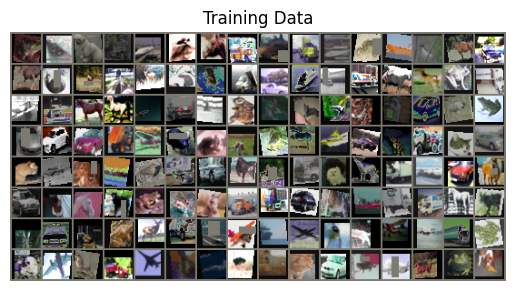

Training Data Labels:
 tensor([6, 3, 5, 9, 0, 3, 7, 9, 7, 9, 8, 6, 8, 2, 7, 1, 2, 3, 4, 2, 4, 3, 5, 9,
        1, 8, 8, 9, 7, 4, 6, 9, 0, 8, 7, 7, 0, 1, 0, 3, 4, 5, 6, 3, 2, 1, 2, 6,
        1, 1, 1, 9, 0, 2, 3, 5, 6, 7, 8, 1, 6, 9, 3, 1, 3, 0, 4, 8, 2, 1, 1, 7,
        7, 9, 5, 4, 9, 8, 1, 7, 1, 3, 7, 5, 6, 6, 7, 9, 9, 1, 4, 8, 9, 9, 7, 3,
        4, 1, 5, 6, 4, 9, 0, 0, 8, 0, 2, 3, 0, 0, 9, 6, 5, 0, 2, 9, 0, 5, 0, 2,
        7, 3, 1, 3, 0, 7, 6, 5])


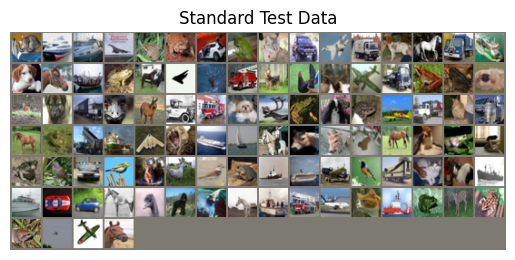

Standard Test Data Labels:
 tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])


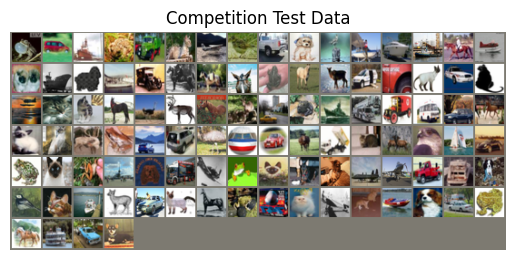

Competition Test Data Labels:
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


In [9]:
trans = CIFARTransforms()
data_module = CIFAR10DataModule(trans.train_transform, trans.test_transform, batch_size=128)
train_loader = data_module.get_train_loader()
test_loader = data_module.get_standard_test_loader()
competition_loader = data_module.get_competition_test_loader()
display_all_data(train_loader, test_loader, competition_loader)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [3, 3, 2, 1]).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]           2,048
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
 AdaptiveAvgPool2d-9             [-1, 64, 1, 1]               0
           Linear-10                    [-1, 4]             256
             ReLU-11                    [-1, 4]               0
           Linear-12                   [-1, 64]             256
          Sigmoid-13                   [-1, 64]               0
          SEBlock-14           [-1, 64,

In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.0007)

warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=5)
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-5)  # Lower eta_min
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[5])

In [12]:
torch.autograd.set_detect_anomaly(True)
train_losses, test_losses, final_accuracy = train(model, optimizer, criterion, scheduler, train_loader, test_loader, device, epochs=150, swa_start_ratio=0.625, batch_norm_free_ratio=0.875, fine_tune_ratio=0.75)

Starting training:
Total epochs: 150
SWA will start at epoch: 93
Fine-tuning (light augmentation) will begin at epoch: 112
BatchNorm freezing will occur at epoch: 131

Epoch 0/149 starting...
   Training completed. Average training loss: 2.0260
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 1.5651, Accuracy: 43.53%

Epoch 1/149 starting...
   Training completed. Average training loss: 1.6984
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 1.1816, Accuracy: 58.35%

Epoch 2/149 starting...
   Training completed. Average training loss: 1.3999
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 1.0753, Accuracy: 62.96%

Epoch 3/149 starting...
   Training completed. Average training loss: 1.2676
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 0.9327, Accuracy: 67.80%

Epoch 4/149 starting...
   Training completed. Average train

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


   Testing completed. Average test loss: 0.7845, Accuracy: 73.28%

Epoch 5/149 starting...
   Training completed. Average training loss: 1.1256
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 0.7577, Accuracy: 73.53%

Epoch 6/149 starting...
   Training completed. Average training loss: 1.0405
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 0.6713, Accuracy: 77.37%

Epoch 7/149 starting...
   Training completed. Average training loss: 0.9742
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 0.6201, Accuracy: 80.89%

Epoch 8/149 starting...
   Training completed. Average training loss: 0.8916
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test loss: 0.5606, Accuracy: 80.81%

Epoch 9/149 starting...
   Training completed. Average training loss: 0.8548
   Scheduler: Normal LR scheduler step executed.
   Testing completed. Average test 

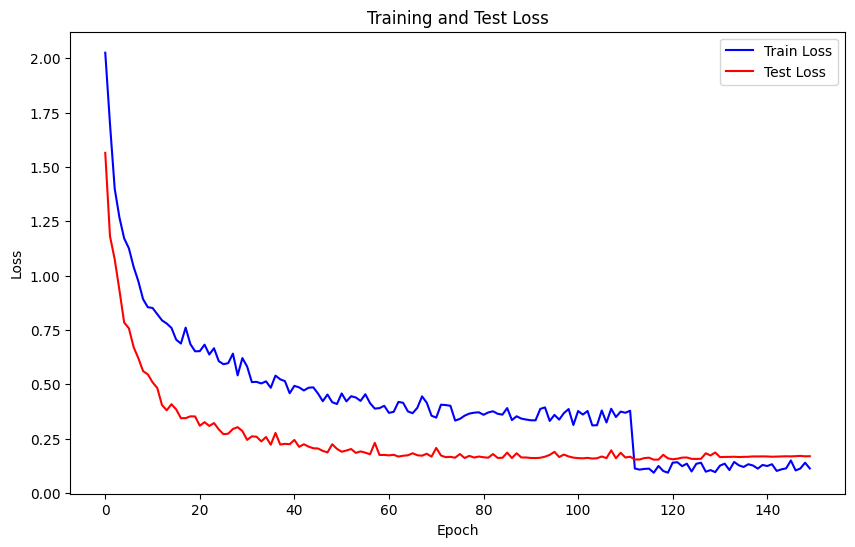

In [13]:
plot_training_curves(train_losses, test_losses, final_accuracy)

In [14]:
model_filename = save_model(model, final_accuracy)

Model saved as model-20250314_0332-95.31.pth


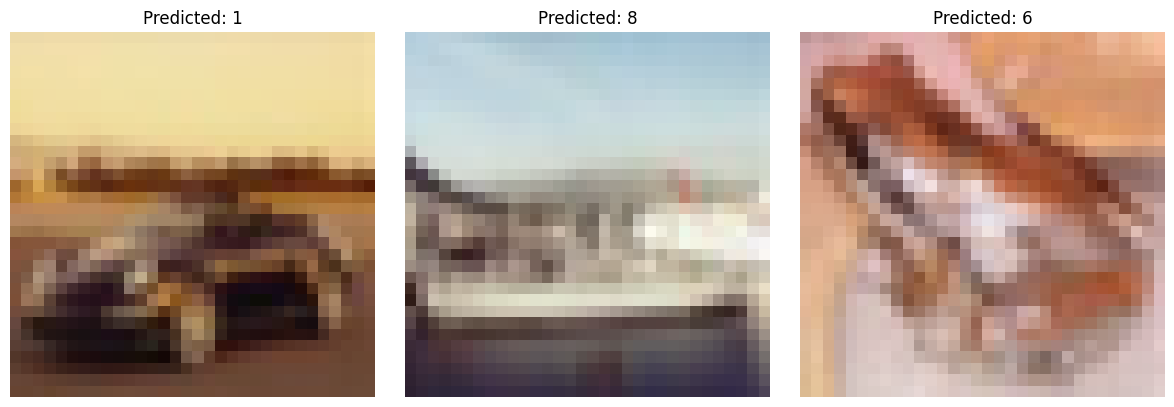

In [15]:
plot_random_competition_predictions(model, competition_loader, num_images=3)

In [16]:
submissions_filename = generate_submission(model, competition_loader, filename_suffix=final_accuracy, device=device)

Submission file saved as submission-95.31.csv
